In [1]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/SAiDL-2024/MoE/dataset.py /content/dataset.py
!cp /content/drive/MyDrive/SAiDL-2024/MoE/trainer.py /content/trainer.py
!cp /content/drive/MyDrive/SAiDL-2024/MoE/tokenizer.py /content/tokenizer.py
!cp /content/drive/MyDrive/SAiDL-2024/MoE/moe.py /content/moe.py
!cp /content/drive/MyDrive/SAiDL-2024/MoE/models.py /content/models.py

Mounted at /content/drive


In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.1 MB/s eta 0:00:00


**Table of contents**<a id='toc0_'></a>    
- [Utils](#toc1_)    
- [Baseline](#toc2_)    
  - [Without MoE with Single Linear Layer in Between](#toc2_1_)    
  - [With MoE](#toc2_2_)    
- [With Top-K Mask](#toc3_)    
- [Noisy Top-k Gating](#toc4_)    
- [Importance with Top-k Mask](#toc5_)    
- [Load with Noisy Top-k Gating](#toc6_)    
- [Plots](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [66]:
import torch
import torch.nn as nn
import pickle
from tokenizer import Tokenizer
from dataset import ConllDataset
from datasets import load_dataset
from models import ConnllBaseLSTM,ConllLSTM_MoE
from trainer import ConllTrainer
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

In [4]:
with open('/content/drive/MyDrive/SAiDL-2024/MoE/conll-assets/idx2token.pkl', 'rb') as file:
    idx2token = pickle.load(file)
with open('/content/drive/MyDrive/SAiDL-2024/MoE/conll-assets/token2idx.pkl', 'rb') as file:
    token2idx = pickle.load(file)

conll_dataset_transformer = load_dataset("conll2003")
conll_tokenizer = Tokenizer(idx2token,token2idx)
conll_dataset_train = ConllDataset(conll_dataset_transformer['train'],conll_tokenizer)
conll_dataset_val = ConllDataset(conll_dataset_transformer['validation'],conll_tokenizer)
embedding_state_dict = torch.load('/content/drive/MyDrive/SAiDL-2024/MoE/conll-assets/conll.glove.6B.50d.pt')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [5]:
ner_tags = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}
ner_tags_inverted = {k:v for v,k in ner_tags.items()}

In [34]:
# Useful Constants
EPOCHS = 10
EMBEDDING_DIM = 50
VOCAB_SIZE = len(idx2token)
NUM_EXPERTS = 8
LSTM_HIDDEN_DIM = 128
EXPERT_HIDDEN_DIM = 128
BATCH_SIZE = 32
NUM_CLASSES = len(ner_tags)
MANUAL_SEED = 1337
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TOP_K = 2
W_IMPORTANCE = 0.1
W_LOAD = 0.1
MODEL_SAVE_PATH = "/content/drive/MyDrive/SAiDL-2024/MoE/models/conll"

In [7]:
train_dataloader = DataLoader(conll_dataset_train,BATCH_SIZE,True)
val_dataloader = DataLoader(conll_dataset_val,BATCH_SIZE)
embedding_state_dict = torch.load('/content/drive/MyDrive/SAiDL-2024/MoE/conll-assets/conll.glove.6B.50d.pt',map_location=DEVICE)

# <a id='toc1_'></a>[Utils](#toc0_)

In [8]:
def get_router_outputs(val_dataloader: DataLoader,
                       model: ConllLSTM_MoE):
    model.eval()
    # Save activations for all val inputs.
    router_activations = []
    # Create hook to only fetch router outputs
    def hook(module,input,output):
      router_activations.append(output[0].cpu())
    router = model.moe.router
    handle = router.register_forward_hook(hook)

    # Loop over dataloader.
    for inputs,_ in val_dataloader:
      inputs = inputs.to(DEVICE)
      with torch.no_grad():
        model(inputs)
    handle.remove()

    # Stack router outputs
    router_activations = torch.concat(router_activations,dim=0)
    router_activations = router_activations.view(-1,router_activations.size(-1))

    # Get max indices
    router_activations = (router_activations != 0).int()

    return router_activations


def plot_expert_distribution(val_dataloader: DataLoader,
                             model: ConllLSTM_MoE):
    # Get router outputs
    router_outputs = get_router_outputs(val_dataloader,model)
    # Get distribution of each expert.
    distribution = router_outputs.sum(dim=0)

    xlabel='Experts'
    ylabel='Tokens Received'
    num_experts = len(distribution)
    plt.figure(figsize=(7, 5))
    plt.bar(np.arange(num_experts), distribution.numpy(), color='steelblue', alpha=0.7, edgecolor='black', width=1.0)

    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(np.arange(num_experts), [f"{i}" for i in range(num_experts)])
    plt.grid(False)

    plt.tight_layout()
    plt.show()



def save(model: nn.Module,
         trainer: ConllTrainer,
         path: str):
    """Saves the model weights and its training history."""
    torch.save({
      'state_dict': model.state_dict(),
      'history': trainer.history
    },path)

# <a id='toc2_'></a>[Baseline](#toc0_)

## <a id='toc2_1_'></a>[Without MoE with Single Linear Layer in Between](#toc0_)

In [9]:
torch.manual_seed(MANUAL_SEED)
lstm_baseline = ConnllBaseLSTM(VOCAB_SIZE,
                               EMBEDDING_DIM,
                               LSTM_HIDDEN_DIM,
                               EXPERT_HIDDEN_DIM,
                               NUM_CLASSES,
                               embedding_state_dict)
lstm_baseline_optim = Adam(filter(lambda p: p.requires_grad, lstm_baseline.parameters()))

In [10]:
lstm_baseline_trainer = ConllTrainer(lstm_baseline,
                                     train_dataloader,
                                     val_dataloader,
                                     lstm_baseline_optim,
                                     DEVICE)

In [11]:
lstm_baseline_trainer.train(EPOCHS)

Epoch 1/10


100%|██████████| 102/102 [00:01<00:00, 61.97batch/s, loss=0.105]


Epoch 1/10
Train loss: 0.3431 | Train accuracy: 0.9092
Val loss: 0.1588 | Val accuracy: 0.9557
 
Epoch 2/10


100%|██████████| 102/102 [00:01<00:00, 64.14batch/s, loss=0.153]


Epoch 2/10
Train loss: 0.1327 | Train accuracy: 0.9611
Val loss: 0.1316 | Val accuracy: 0.9623
 
Epoch 3/10


100%|██████████| 102/102 [00:01<00:00, 64.23batch/s, loss=0.107]


Epoch 3/10
Train loss: 0.1009 | Train accuracy: 0.9698
Val loss: 0.1071 | Val accuracy: 0.9678
 
Epoch 4/10


100%|██████████| 102/102 [00:01<00:00, 63.34batch/s, loss=0.119]


Epoch 4/10
Train loss: 0.0812 | Train accuracy: 0.9760
Val loss: 0.0980 | Val accuracy: 0.9711
 
Epoch 5/10


100%|██████████| 102/102 [00:02<00:00, 49.86batch/s, loss=0.144]


Epoch 5/10
Train loss: 0.0661 | Train accuracy: 0.9803
Val loss: 0.1068 | Val accuracy: 0.9671
 
Epoch 6/10


100%|██████████| 102/102 [00:02<00:00, 47.10batch/s, loss=0.164]


Epoch 6/10
Train loss: 0.0548 | Train accuracy: 0.9835
Val loss: 0.0978 | Val accuracy: 0.9713
 
Epoch 7/10


100%|██████████| 102/102 [00:02<00:00, 50.32batch/s, loss=0.136]


Epoch 7/10
Train loss: 0.0457 | Train accuracy: 0.9861
Val loss: 0.0990 | Val accuracy: 0.9727
 
Epoch 8/10


100%|██████████| 102/102 [00:01<00:00, 63.47batch/s, loss=0.188]


Epoch 8/10
Train loss: 0.0378 | Train accuracy: 0.9887
Val loss: 0.1014 | Val accuracy: 0.9718
 
Epoch 9/10


100%|██████████| 102/102 [00:01<00:00, 65.03batch/s, loss=0.155]


Epoch 9/10
Train loss: 0.0311 | Train accuracy: 0.9908
Val loss: 0.1195 | Val accuracy: 0.9705
 
Epoch 10/10


100%|██████████| 102/102 [00:01<00:00, 63.59batch/s, loss=0.168]


Epoch 10/10
Train loss: 0.0264 | Train accuracy: 0.9920
Val loss: 0.1179 | Val accuracy: 0.9708
 


In [12]:
print(f"Final negative validation log-likelihood: {lstm_baseline_trainer.history['val_loss'][-1]}")
print(f"Final negative validation accuracy: {lstm_baseline_trainer.history['val_acc'][-1]}")

Final negative validation log-likelihood: 0.11791758850421163
Final negative validation accuracy: 0.9708149994159105


In [13]:
save(lstm_baseline,lstm_baseline_trainer,f'{MODEL_SAVE_PATH}/lstm_baseline.pt')

## <a id='toc2_2_'></a>[With MoE](#toc0_)

In [14]:
torch.manual_seed(MANUAL_SEED)
moe_baseline = ConllLSTM_MoE(VOCAB_SIZE,
                             EMBEDDING_DIM,
                             LSTM_HIDDEN_DIM,
                             EXPERT_HIDDEN_DIM,
                             NUM_CLASSES,
                             embedding_state_dict,
                             'top_k',
                             NUM_EXPERTS,
                             TOP_K)
moe_baseline_optim = Adam(filter(lambda p: p.requires_grad, moe_baseline.parameters()))

In [15]:
moe_baseline_trainer = ConllTrainer(moe_baseline,
                                     train_dataloader,
                                     val_dataloader,
                                     moe_baseline_optim,
                                     DEVICE)

In [16]:
moe_baseline_trainer.train(EPOCHS)

Epoch 1/10


100%|██████████| 102/102 [00:02<00:00, 39.07batch/s, loss=0.13]


Epoch 1/10
Train loss: 0.3806 | Train accuracy: 0.9016
Val loss: 0.1748 | Val accuracy: 0.9506
 
Epoch 2/10


100%|██████████| 102/102 [00:02<00:00, 47.86batch/s, loss=0.101]


Epoch 2/10
Train loss: 0.1435 | Train accuracy: 0.9576
Val loss: 0.1327 | Val accuracy: 0.9616
 
Epoch 3/10


100%|██████████| 102/102 [00:02<00:00, 40.02batch/s, loss=0.111]


Epoch 3/10
Train loss: 0.1061 | Train accuracy: 0.9684
Val loss: 0.1080 | Val accuracy: 0.9687
 
Epoch 4/10


100%|██████████| 102/102 [00:02<00:00, 46.61batch/s, loss=0.129]


Epoch 4/10
Train loss: 0.0859 | Train accuracy: 0.9742
Val loss: 0.1055 | Val accuracy: 0.9681
 
Epoch 5/10


100%|██████████| 102/102 [00:02<00:00, 38.58batch/s, loss=0.12]


Epoch 5/10
Train loss: 0.0707 | Train accuracy: 0.9784
Val loss: 0.0995 | Val accuracy: 0.9692
 
Epoch 6/10


100%|██████████| 102/102 [00:02<00:00, 46.15batch/s, loss=0.128]


Epoch 6/10
Train loss: 0.0580 | Train accuracy: 0.9827
Val loss: 0.1028 | Val accuracy: 0.9698
 
Epoch 7/10


100%|██████████| 102/102 [00:02<00:00, 39.55batch/s, loss=0.128]


Epoch 7/10
Train loss: 0.0477 | Train accuracy: 0.9856
Val loss: 0.0995 | Val accuracy: 0.9728
 
Epoch 8/10


100%|██████████| 102/102 [00:02<00:00, 46.32batch/s, loss=0.144]


Epoch 8/10
Train loss: 0.0386 | Train accuracy: 0.9883
Val loss: 0.1077 | Val accuracy: 0.9730
 
Epoch 9/10


100%|██████████| 102/102 [00:02<00:00, 36.74batch/s, loss=0.211]


Epoch 9/10
Train loss: 0.0319 | Train accuracy: 0.9905
Val loss: 0.1077 | Val accuracy: 0.9717
 
Epoch 10/10


100%|██████████| 102/102 [00:02<00:00, 45.83batch/s, loss=0.179]

Epoch 10/10
Train loss: 0.0266 | Train accuracy: 0.9921
Val loss: 0.1142 | Val accuracy: 0.9708
 


In [17]:
save(moe_baseline,moe_baseline_trainer,f'{MODEL_SAVE_PATH}/conll/moe_baseline.pt')

In [18]:
print(f"Final negative validation log-likelihood: {moe_baseline_trainer.history['val_loss'][-1]}")
print(f"Final negative validation accuracy: {moe_baseline_trainer.history['val_acc'][-1]}")

Final negative validation log-likelihood: 0.11421528546427498
Final negative validation accuracy: 0.9707565904754488


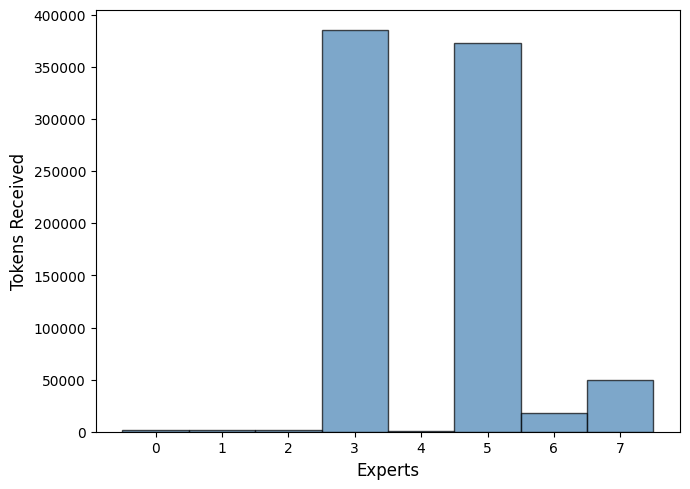

In [19]:
plot_expert_distribution(val_dataloader,moe_baseline)

# <a id='toc3_'></a>[With Top-K Mask](#toc0_)

In [20]:
torch.manual_seed(MANUAL_SEED)
moe_topk_mask = ConllLSTM_MoE(VOCAB_SIZE,
                             EMBEDDING_DIM,
                             LSTM_HIDDEN_DIM,
                             EXPERT_HIDDEN_DIM,
                             NUM_CLASSES,
                             embedding_state_dict,
                             'top_k_mask',
                             NUM_EXPERTS,
                             TOP_K)
moe_topk_mask_optim = Adam(filter(lambda p: p.requires_grad, moe_topk_mask.parameters()))

In [21]:
moe_topk_mask_trainer = ConllTrainer(moe_topk_mask,
                                     train_dataloader,
                                     val_dataloader,
                                     moe_topk_mask_optim,
                                     DEVICE)

In [22]:
moe_topk_mask_trainer.train(EPOCHS)

Epoch 1/10


100%|██████████| 102/102 [00:02<00:00, 44.76batch/s, loss=0.12]


Epoch 1/10
Train loss: 0.3412 | Train accuracy: 0.9115
Val loss: 0.1556 | Val accuracy: 0.9572
 
Epoch 2/10


100%|██████████| 102/102 [00:02<00:00, 45.18batch/s, loss=0.115]


Epoch 2/10
Train loss: 0.1297 | Train accuracy: 0.9615
Val loss: 0.1158 | Val accuracy: 0.9665
 
Epoch 3/10


100%|██████████| 102/102 [00:02<00:00, 46.51batch/s, loss=0.113]


Epoch 3/10
Train loss: 0.0960 | Train accuracy: 0.9716
Val loss: 0.1025 | Val accuracy: 0.9704
 
Epoch 4/10


100%|██████████| 102/102 [00:02<00:00, 46.42batch/s, loss=0.139]


Epoch 4/10
Train loss: 0.0768 | Train accuracy: 0.9769
Val loss: 0.0971 | Val accuracy: 0.9699
 
Epoch 5/10


100%|██████████| 102/102 [00:02<00:00, 45.94batch/s, loss=0.12]


Epoch 5/10
Train loss: 0.0606 | Train accuracy: 0.9818
Val loss: 0.0930 | Val accuracy: 0.9719
 
Epoch 6/10


100%|██████████| 102/102 [00:02<00:00, 46.08batch/s, loss=0.184]


Epoch 6/10
Train loss: 0.0478 | Train accuracy: 0.9858
Val loss: 0.0991 | Val accuracy: 0.9712
 
Epoch 7/10


100%|██████████| 102/102 [00:02<00:00, 45.08batch/s, loss=0.162]


Epoch 7/10
Train loss: 0.0395 | Train accuracy: 0.9881
Val loss: 0.1019 | Val accuracy: 0.9730
 
Epoch 8/10


100%|██████████| 102/102 [00:02<00:00, 39.23batch/s, loss=0.184]


Epoch 8/10
Train loss: 0.0321 | Train accuracy: 0.9902
Val loss: 0.1108 | Val accuracy: 0.9733
 
Epoch 9/10


100%|██████████| 102/102 [00:02<00:00, 45.86batch/s, loss=0.157]


Epoch 9/10
Train loss: 0.0260 | Train accuracy: 0.9920
Val loss: 0.1061 | Val accuracy: 0.9732
 
Epoch 10/10


100%|██████████| 102/102 [00:02<00:00, 36.76batch/s, loss=0.212]


Epoch 10/10
Train loss: 0.0230 | Train accuracy: 0.9928
Val loss: 0.1173 | Val accuracy: 0.9726
 


In [23]:
save(moe_topk_mask,moe_topk_mask_trainer,f'{MODEL_SAVE_PATH}/moe_top_k_mask.pt')

In [24]:
print(f"Final negative validation log-likelihood: {moe_topk_mask_trainer.history['val_loss'][-1]}")
print(f"Final negative validation accuracy: {moe_topk_mask_trainer.history['val_acc'][-1]}")

Final negative validation log-likelihood: 0.117290462816206
Final negative validation accuracy: 0.972625676570227


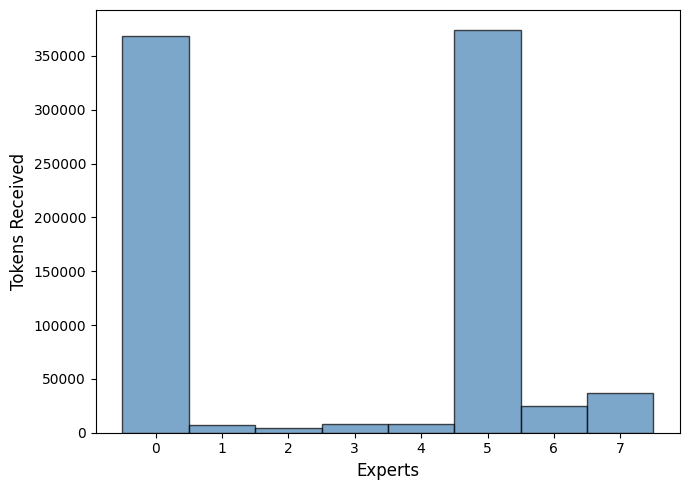

In [25]:
plot_expert_distribution(val_dataloader,moe_topk_mask)

# <a id='toc4_'></a>[Noisy Top-k Gating](#toc0_)

In [26]:
torch.manual_seed(MANUAL_SEED)
moe_noisy = ConllLSTM_MoE(VOCAB_SIZE,
                             EMBEDDING_DIM,
                             LSTM_HIDDEN_DIM,
                             EXPERT_HIDDEN_DIM,
                             NUM_CLASSES,
                             embedding_state_dict,
                             'noisy_top_k',
                             NUM_EXPERTS,
                             TOP_K)
moe_noisy_optim = Adam(filter(lambda p: p.requires_grad, moe_noisy.parameters()))

In [27]:
moe_noisy_trainer = ConllTrainer(moe_noisy,
                                 train_dataloader,
                                 val_dataloader,
                                 moe_noisy_optim,
                                 DEVICE)

In [28]:
moe_noisy_trainer.train(EPOCHS)

Epoch 1/10


100%|██████████| 102/102 [00:02<00:00, 42.99batch/s, loss=0.131]


Epoch 1/10
Train loss: 0.3739 | Train accuracy: 0.9003
Val loss: 0.1674 | Val accuracy: 0.9509
 
Epoch 2/10


100%|██████████| 102/102 [00:02<00:00, 44.07batch/s, loss=0.158]


Epoch 2/10
Train loss: 0.1399 | Train accuracy: 0.9595
Val loss: 0.1357 | Val accuracy: 0.9635
 
Epoch 3/10


100%|██████████| 102/102 [00:02<00:00, 40.42batch/s, loss=0.0981]


Epoch 3/10
Train loss: 0.1063 | Train accuracy: 0.9688
Val loss: 0.1045 | Val accuracy: 0.9697
 
Epoch 4/10


100%|██████████| 102/102 [00:02<00:00, 42.88batch/s, loss=0.154]


Epoch 4/10
Train loss: 0.0858 | Train accuracy: 0.9743
Val loss: 0.1013 | Val accuracy: 0.9716
 
Epoch 5/10


100%|██████████| 102/102 [00:02<00:00, 43.76batch/s, loss=0.11]


Epoch 5/10
Train loss: 0.0715 | Train accuracy: 0.9786
Val loss: 0.0989 | Val accuracy: 0.9714
 
Epoch 6/10


100%|██████████| 102/102 [00:02<00:00, 43.96batch/s, loss=0.144]


Epoch 6/10
Train loss: 0.0589 | Train accuracy: 0.9825
Val loss: 0.0949 | Val accuracy: 0.9727
 
Epoch 7/10


100%|██████████| 102/102 [00:02<00:00, 40.13batch/s, loss=0.15]


Epoch 7/10
Train loss: 0.0487 | Train accuracy: 0.9856
Val loss: 0.1025 | Val accuracy: 0.9736
 
Epoch 8/10


100%|██████████| 102/102 [00:02<00:00, 43.30batch/s, loss=0.131]


Epoch 8/10
Train loss: 0.0409 | Train accuracy: 0.9878
Val loss: 0.1018 | Val accuracy: 0.9717
 
Epoch 9/10


100%|██████████| 102/102 [00:02<00:00, 43.86batch/s, loss=0.18]


Epoch 9/10
Train loss: 0.0338 | Train accuracy: 0.9898
Val loss: 0.1010 | Val accuracy: 0.9731
 
Epoch 10/10


100%|██████████| 102/102 [00:02<00:00, 40.54batch/s, loss=0.213]

Epoch 10/10
Train loss: 0.0269 | Train accuracy: 0.9919
Val loss: 0.1087 | Val accuracy: 0.9732
 


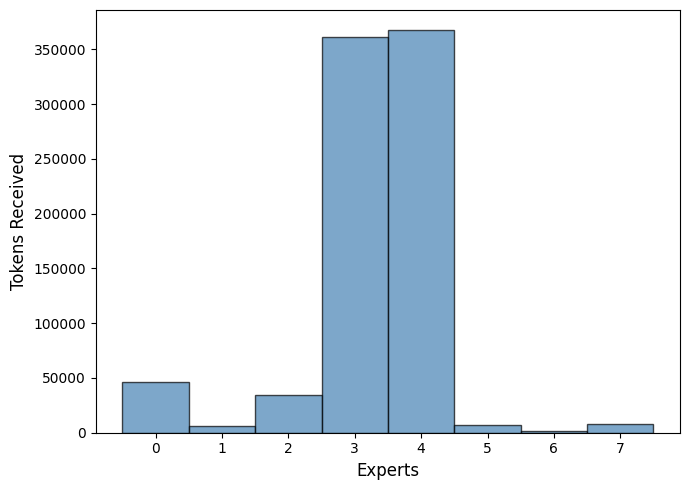

In [29]:
plot_expert_distribution(val_dataloader,moe_noisy)

In [30]:
save(moe_noisy,moe_noisy_trainer,f'{MODEL_SAVE_PATH}/moe_noisy.pt')

In [31]:
print(f"Final negative validation log-likelihood: {moe_noisy_trainer.history['val_loss'][-1]}")
print(f"Final negative validation accuracy: {moe_noisy_trainer.history['val_acc'][-1]}")

Final negative validation log-likelihood: 0.1086795807742758
Final negative validation accuracy: 0.973170826681204


# <a id='toc5_'></a>[Importance with Top-k Mask](#toc0_)

In [32]:
torch.manual_seed(MANUAL_SEED)
moe_importance_mask = ConllLSTM_MoE(VOCAB_SIZE,
                             EMBEDDING_DIM,
                             LSTM_HIDDEN_DIM,
                             EXPERT_HIDDEN_DIM,
                             NUM_CLASSES,
                             embedding_state_dict,
                             'top_k_mask',
                             NUM_EXPERTS,
                             TOP_K)
moe_importance_mask_optim = Adam(filter(lambda p: p.requires_grad, moe_importance_mask.parameters()))

In [35]:
moe_importance_mask_trainer = ConllTrainer(moe_importance_mask,
                                     train_dataloader,
                                     val_dataloader,
                                     moe_importance_mask_optim,
                                     DEVICE,
                                     importance_cv_squared = True,
                                     w_importance=W_IMPORTANCE)

In [36]:
moe_importance_mask_trainer.train(EPOCHS)

Epoch 1/10


100%|██████████| 102/102 [00:02<00:00, 38.04batch/s, loss=0.114]


Epoch 1/10
Train loss: 0.5785 | Train accuracy: 0.9146
Val loss: 0.1540 | Val accuracy: 0.9553
 
Epoch 2/10


100%|██████████| 102/102 [00:02<00:00, 46.13batch/s, loss=0.126]


Epoch 2/10
Train loss: 0.3720 | Train accuracy: 0.9608
Val loss: 0.1186 | Val accuracy: 0.9653
 
Epoch 3/10


100%|██████████| 102/102 [00:02<00:00, 44.93batch/s, loss=0.122]


Epoch 3/10
Train loss: 0.3363 | Train accuracy: 0.9711
Val loss: 0.1015 | Val accuracy: 0.9703
 
Epoch 4/10


100%|██████████| 102/102 [00:04<00:00, 24.67batch/s, loss=0.157]


Epoch 4/10
Train loss: 0.3129 | Train accuracy: 0.9766
Val loss: 0.0997 | Val accuracy: 0.9692
 
Epoch 5/10


100%|██████████| 102/102 [00:02<00:00, 45.47batch/s, loss=0.132]


Epoch 5/10
Train loss: 0.2978 | Train accuracy: 0.9807
Val loss: 0.0978 | Val accuracy: 0.9701
 
Epoch 6/10


100%|██████████| 102/102 [00:02<00:00, 39.84batch/s, loss=0.15]


Epoch 6/10
Train loss: 0.2795 | Train accuracy: 0.9848
Val loss: 0.0951 | Val accuracy: 0.9714
 
Epoch 7/10


100%|██████████| 102/102 [00:02<00:00, 44.24batch/s, loss=0.154]


Epoch 7/10
Train loss: 0.2697 | Train accuracy: 0.9876
Val loss: 0.0935 | Val accuracy: 0.9739
 
Epoch 8/10


100%|██████████| 102/102 [00:02<00:00, 41.36batch/s, loss=0.162]


Epoch 8/10
Train loss: 0.2581 | Train accuracy: 0.9899
Val loss: 0.1045 | Val accuracy: 0.9732
 
Epoch 9/10


100%|██████████| 102/102 [00:02<00:00, 35.55batch/s, loss=0.207]


Epoch 9/10
Train loss: 0.2468 | Train accuracy: 0.9917
Val loss: 0.1047 | Val accuracy: 0.9731
 
Epoch 10/10


100%|██████████| 102/102 [00:02<00:00, 41.49batch/s, loss=0.189]

Epoch 10/10
Train loss: 0.2353 | Train accuracy: 0.9932
Val loss: 0.1095 | Val accuracy: 0.9740
 


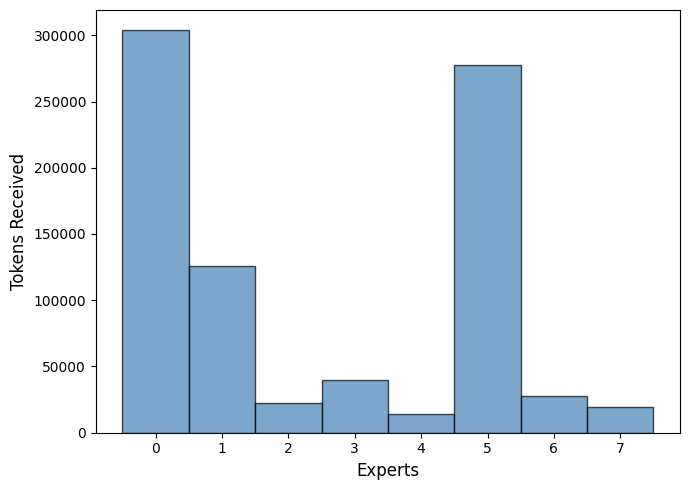

In [37]:
plot_expert_distribution(val_dataloader,moe_importance_mask)

In [38]:
save(moe_importance_mask,moe_importance_mask_trainer,f'{MODEL_SAVE_PATH}/moe_importance_mask.pt')

In [39]:
print(f"Final negative validation log-likelihood: {moe_importance_mask_trainer.history['val_loss'][-1]}")
print(f"Final negative validation accuracy: {moe_importance_mask_trainer.history['val_acc'][-1]}")

Final negative validation log-likelihood: 0.10953674790917099
Final negative validation accuracy: 0.9740274911413107


# <a id='toc6_'></a>[Load with Noisy Top-k Gating](#toc0_)

In [60]:
torch.manual_seed(MANUAL_SEED)
moe_noisy_load = ConllLSTM_MoE(VOCAB_SIZE,
                             EMBEDDING_DIM,
                             LSTM_HIDDEN_DIM,
                             EXPERT_HIDDEN_DIM,
                             NUM_CLASSES,
                             embedding_state_dict,
                             'noisy_top_k',
                             NUM_EXPERTS,
                             TOP_K)
moe_noisy_load_optim = Adam(filter(lambda p: p.requires_grad, moe_noisy_load.parameters()))

In [61]:
moe_noisy_load_trainer = ConllTrainer(moe_noisy_load,
                                     train_dataloader,
                                     val_dataloader,
                                     moe_noisy_load_optim,
                                     DEVICE,
                                     load_cv_squared = True,
                                     w_load=W_LOAD)

In [62]:
moe_noisy_load_trainer.train(EPOCHS)

Epoch 1/10


100%|██████████| 102/102 [00:02<00:00, 46.95batch/s, loss=0.125]


Epoch 1/10
Train loss: 0.3768 | Train accuracy: 0.8997
Val loss: 0.1778 | Val accuracy: 0.9478
 
Epoch 2/10


100%|██████████| 102/102 [00:02<00:00, 41.49batch/s, loss=0.143]


Epoch 2/10
Train loss: 0.1444 | Train accuracy: 0.9586
Val loss: 0.1369 | Val accuracy: 0.9617
 
Epoch 3/10


100%|██████████| 102/102 [00:02<00:00, 37.33batch/s, loss=0.103]


Epoch 3/10
Train loss: 0.1091 | Train accuracy: 0.9679
Val loss: 0.1066 | Val accuracy: 0.9681
 
Epoch 4/10


100%|██████████| 102/102 [00:02<00:00, 46.43batch/s, loss=0.128]


Epoch 4/10
Train loss: 0.0874 | Train accuracy: 0.9741
Val loss: 0.1040 | Val accuracy: 0.9707
 
Epoch 5/10


100%|██████████| 102/102 [00:02<00:00, 41.47batch/s, loss=0.11]


Epoch 5/10
Train loss: 0.0741 | Train accuracy: 0.9779
Val loss: 0.0970 | Val accuracy: 0.9712
 
Epoch 6/10


100%|██████████| 102/102 [00:02<00:00, 45.00batch/s, loss=0.145]


Epoch 6/10
Train loss: 0.0605 | Train accuracy: 0.9820
Val loss: 0.0965 | Val accuracy: 0.9718
 
Epoch 7/10


100%|██████████| 102/102 [00:02<00:00, 46.06batch/s, loss=0.159]


Epoch 7/10
Train loss: 0.0504 | Train accuracy: 0.9847
Val loss: 0.1018 | Val accuracy: 0.9726
 
Epoch 8/10


100%|██████████| 102/102 [00:03<00:00, 33.66batch/s, loss=0.127]


Epoch 8/10
Train loss: 0.0416 | Train accuracy: 0.9874
Val loss: 0.1026 | Val accuracy: 0.9718
 
Epoch 9/10


100%|██████████| 102/102 [00:02<00:00, 34.71batch/s, loss=0.16]


Epoch 9/10
Train loss: 0.0341 | Train accuracy: 0.9901
Val loss: 0.1124 | Val accuracy: 0.9719
 
Epoch 10/10


100%|██████████| 102/102 [00:02<00:00, 45.24batch/s, loss=0.16]

Epoch 10/10
Train loss: 0.0280 | Train accuracy: 0.9917
Val loss: 0.1133 | Val accuracy: 0.9731
 


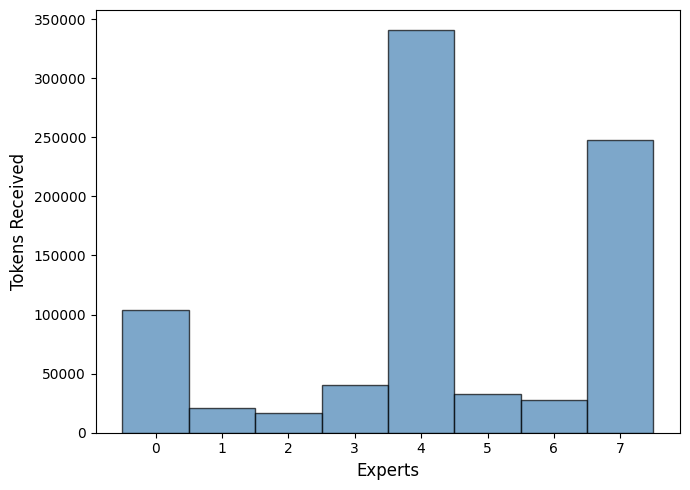

In [63]:
plot_expert_distribution(val_dataloader,moe_noisy_load)

In [64]:
save(moe_noisy_load,moe_noisy_load_trainer,f'{MODEL_SAVE_PATH}/moe_noisy_load_importance.pt')

In [65]:
print(f"Final negative validation log-likelihood: {moe_noisy_load_trainer.history['val_loss'][-1]}")
print(f"Final negative validation accuracy: {moe_noisy_load_trainer.history['val_acc'][-1]}")

Final negative validation log-likelihood: 0.11328012029473172
Final negative validation accuracy: 0.973073478447101


# <a id='toc7_'></a>[Plots](#toc0_)

In [67]:
trainers = {
    'LSTM Baseline':lstm_baseline_trainer,
    'MoE Naive':moe_baseline_trainer,
    'MoE Mask':moe_topk_mask_trainer,
    'MoE Noisy TopK':moe_noisy_trainer,
    'MoE Importance':moe_importance_mask_trainer,
    'MoE Load':moe_noisy_load_trainer,
}

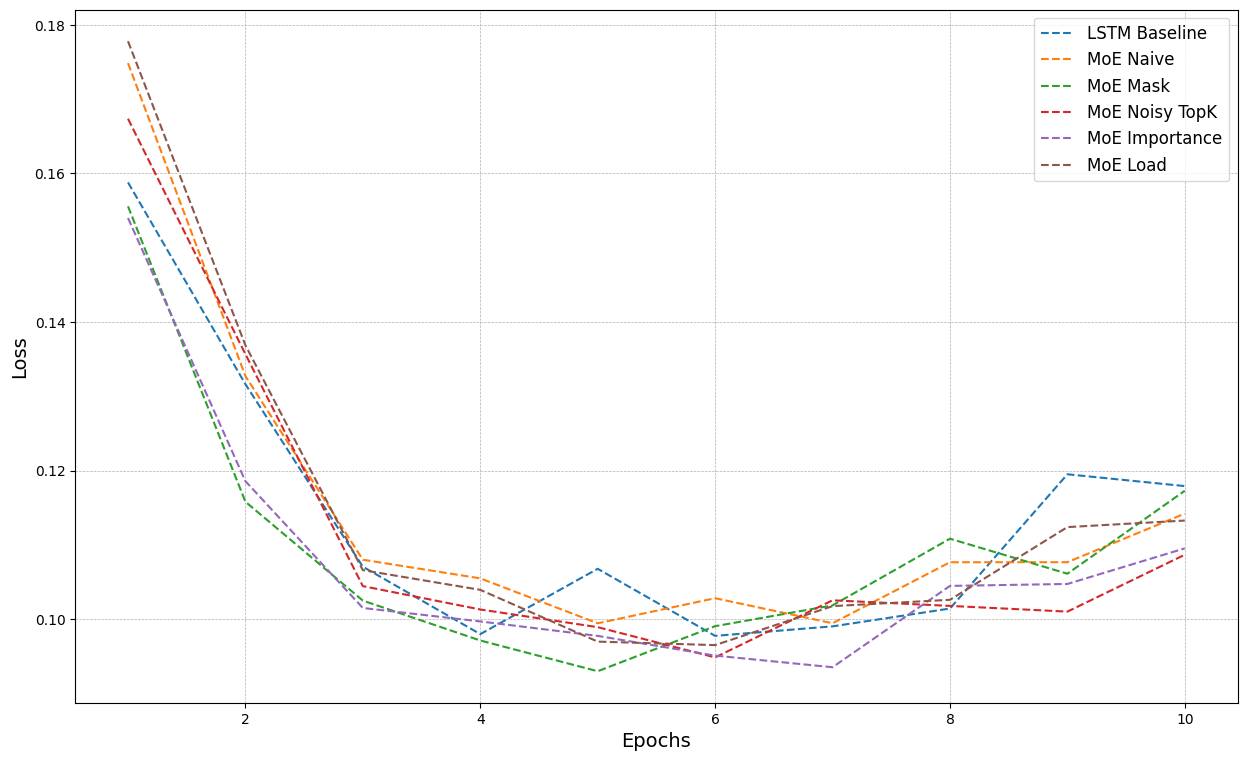

In [101]:
value = 'val_loss'
plt.figure(figsize=(15,9))
for trainer in trainers:
    epochs = range(1, len(trainers[trainer].history[value]) + 1)
    plt.plot(epochs, trainers[trainer].history[value],'--' ,label=f"{trainer}")

plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)
plt.show()

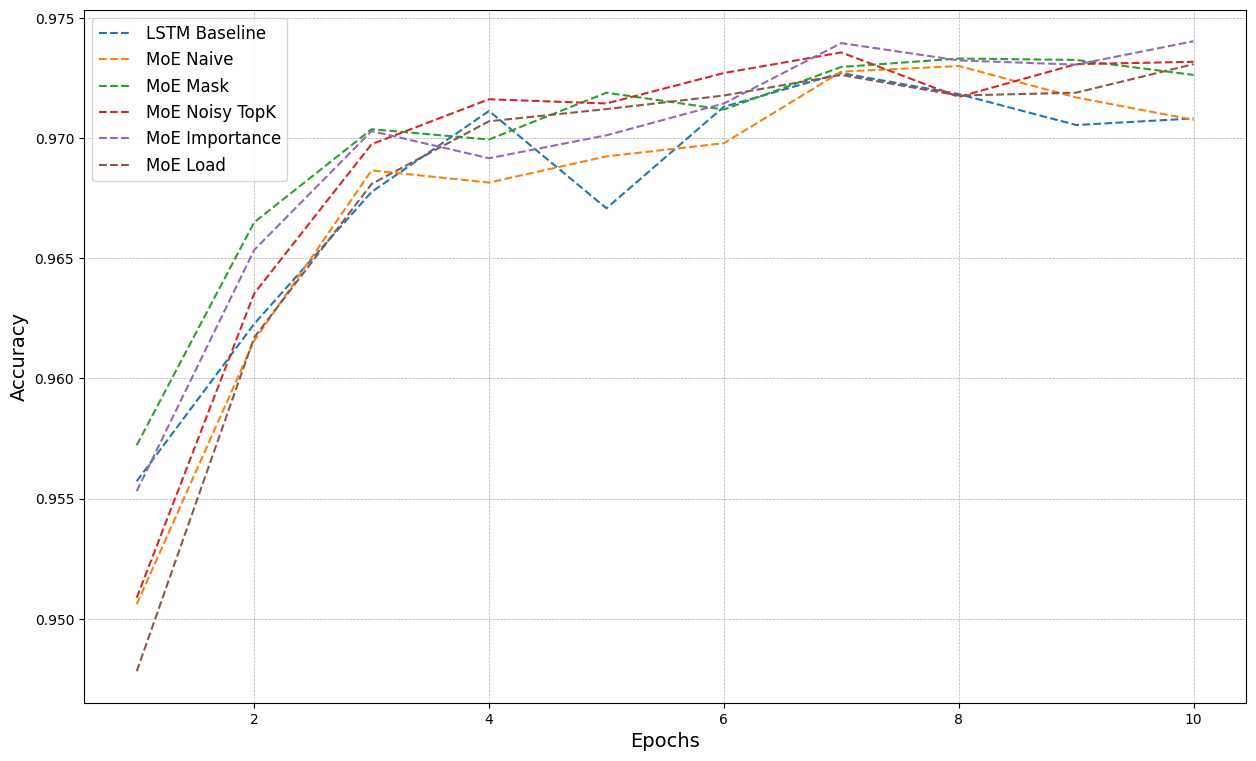

In [102]:
value = 'val_acc'
plt.figure(figsize=(15, 9))
for trainer in trainers:
    epochs = range(1, len(trainers[trainer].history[value]) + 1)
    plt.plot(epochs, trainers[trainer].history[value],'--' ,label=f"{trainer}")

plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)
plt.show()